# Import Libraries

In [427]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

from matplotlib.patches import Rectangle
import os
from skimage import io
from skimage import exposure
import natsort as ns
import multiprocessing
from tqdm import tqdm_notebook
from skimage.util import *
import sklearn

# Load Images

In [428]:
path = os.getcwd()

im_dir = r''+ path + '/Zurich_dataset/images_tif/'
gt_dir = r''+ path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

def im_load(path, offset=2): # for now, only return highest [max_size] pixels, multiple of patch_size
    """load a TIF image"""
    image = np.asarray(io.imread(path)).astype(float)
    #print(image.shape)
    return np.asarray(image[offset:,offset:,:])


images: 20 
ground truth images: 20 


In [429]:
max_size = 512
imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])
print(imgs.shape)

(20,)


In [430]:
# Loaded a set of images
def imgs_stretch_eq(imgs):
    imgs_stretch, imgs_eq = [], []
    for im in imgs:
        # Contrast stretching
        p2, p98 = np.percentile(im, (2, 98))
        img_stretch = im.copy()
        img_eq = im.copy()
        for band in range(im.shape[-1]):
            img_stretch[:,:,band] = exposure.rescale_intensity(im[:,:,band], in_range=(p2, p98))
            img_eq[:,:,band] = exposure.equalize_hist(img_stretch[:,:,band])
        
        # append images
        imgs_stretch.append(img_stretch)
        imgs_eq.append(img_eq)
        
    # convert to np arrays
    imgs_stretch = np.asarray(imgs_stretch)
    imgs_eq = np.asarray(imgs_eq)
    return imgs_stretch, imgs_eq 

imgs_stretch, imgs_eq = imgs_stretch_eq(imgs)

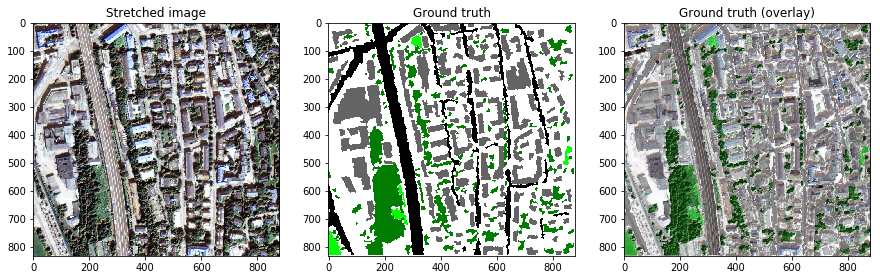

In [431]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 1
alpha=.6
overlay = imgs_eq[i][:,:,:3]*alpha+gt[i]/255*(1-alpha)

# TODO don't stretch image

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs_eq[i][:,:,:3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

In [432]:
imgs = imgs_eq # continue using stretched image

In [433]:
print(np.shape(imgs))
print(np.shape(gt))

(20,)
(20,)


## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [434]:
# get label corresponding to each color
from collections import OrderedDict

legend = OrderedDict((('Background',[255, 255, 255]),
          ('Roads',[0, 0, 0]),
          ('Buildings',[100, 100, 100]),
          ('Trees',[0, 125, 0]),
          ('Grass',[0, 255, 0]),
          ('Bare Soil',[150, 80, 0]),
          ('Water',[0, 0, 150]),
          ('Railways',[255, 255, 0]),
          ('Swimming Pools',[150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

In [436]:
def gt_color_to_label(gt, maj = False):
    """
    Transform a set of GT image in value range [0, 255] of shape (n_images, width, height, 3) 
    to a set of GT labels of shape (n_images, width, height)
    """
    
    # sum of distinct color values
    gt_new = gt.copy()
    

    # replace colors by new values
    for i in tqdm(range(len(colors))):
        for j in range(np.shape(gt)[0]):# loop over images
            gt_new[j][:,:,0][np.all(gt[j]==colors[i],axis=-1)] = i #np.argsort(colors)[i]    
        
    gt_new = np.asarray([gt_new[j][:,:,0] for j in range(np.shape(gt)[0])])  # only keep first band = label
    
    if maj:
        # return only majority label for each patch
        gt_maj_label = []
        for i in range(len(gt)):
            counts = np.bincount(gt_new[i].flatten())
            gt_maj_label.append(np.argmax(counts))

        gt_new = np.asarray([gt_maj_label]).T
        
    return gt_new

def gt_label_to_color(gt):
    """
    Transform a set of GT labels of shape (n_images, width, height)
    to a set of GT images in value range [0,1] of shape (n_images, width, height, 3) """
    gt_new = np.zeros(gt.shape+(3,))
    for i in range(len(colors)): # loop colors
        gt_new[gt == i,:] = np.divide(colors[i],255)
    return gt_new

In [437]:
gt_maj_label = gt_color_to_label(gt)
flatten = lambda l: [item for sublist in l for item in sublist]
flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


In [438]:
gt_colors = gt_label_to_color(np.asarray(gt_maj_label))

[0. 1. 2. 3. 4. 5. 6. 7. 8.] [10495083  3802130  5374142  2531556  1864437   234618  1267384   342084
    33525]


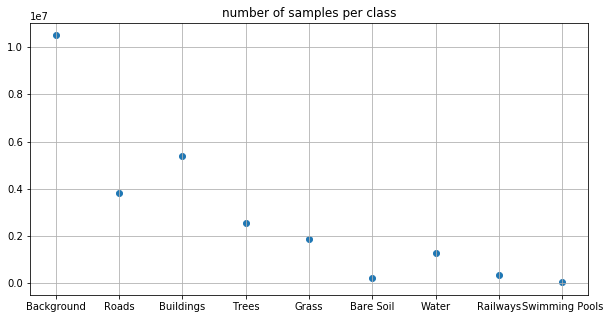

In [439]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels,return_counts=True)
print(unique, counts)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)
ax.scatter(unique,counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

## Get patches

In [485]:
def get_padded_patches(images, patch_size = 64, window_size = 64):
    """
    get padded (mirror) patches for all images
    """
    patches = []
    for im in tqdm_notebook(images): # loop over images
        patches_im = np.zeros([int(im.shape[0]/patch_size),int(im.shape[1]/patch_size), window_size, window_size, im.shape[2]])    
        max_x = np.mod(im.shape[0],patch_size)
        max_y = np.mod(im.shape[1],patch_size)
        for i in range(np.shape(im)[2]): # loop over bands, pad original image
            padded = np.lib.pad(im[:-max_x,:-max_y,i], int(np.floor((window_size-patch_size)/2)), 'reflect')
            
            # define image subarea in which to extract patches (divisible by patch_size)
            patches_im[:,:,:,:,i] = view_as_windows(padded, window_size, step=patch_size)
            
        n_patches = int(im.shape[0]/patch_size)*int(im.shape[1]/patch_size) # 25*25 = 625 per image
        patches_im = np.reshape(patches_im, (n_patches, window_size, window_size, im.shape[2]))

        # TODO reshape patches (first dim)
        patches.append(patches_im)
    patches = np.array(patches)
    patches =  np.asarray([patches[i][j] for i in range(len(patches)) for j in range(len(patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return patches

def get_gt_patches(images_gt, patch_size = 64):
    """
    get ground truth patches for all images
    """
    gt_patches = []
    for im in tqdm_notebook(images_gt):
        max_x = np.mod(im.shape[0],patch_size)
        max_y = np.mod(im.shape[1],patch_size)
        patches_im_gt = view_as_blocks(im[:-max_x,:-max_y], block_shape=(patch_size, patch_size))
        n_patches = int(im.shape[0]/patch_size) * int(im.shape[1]/patch_size) # 25*25 = 625 per image
        patches_im_gt = np.reshape(patches_im_gt, (n_patches, patch_size, patch_size))

        gt_patches.append(patches_im_gt)
    gt_patches = np.array(gt_patches)
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return np.asarray(gt_patches)

In [532]:
patch_size = 256
im_patches = get_padded_patches(imgs, patch_size = patch_size, window_size = patch_size)
gt_patches = get_gt_patches(gt, patch_size = patch_size)
print(im_patches.shape)
print(gt_patches.shape)



(315, 256, 256, 4)
(315, 256, 256)


In [533]:
gt_patches_color=gt_label_to_color(gt_patches)

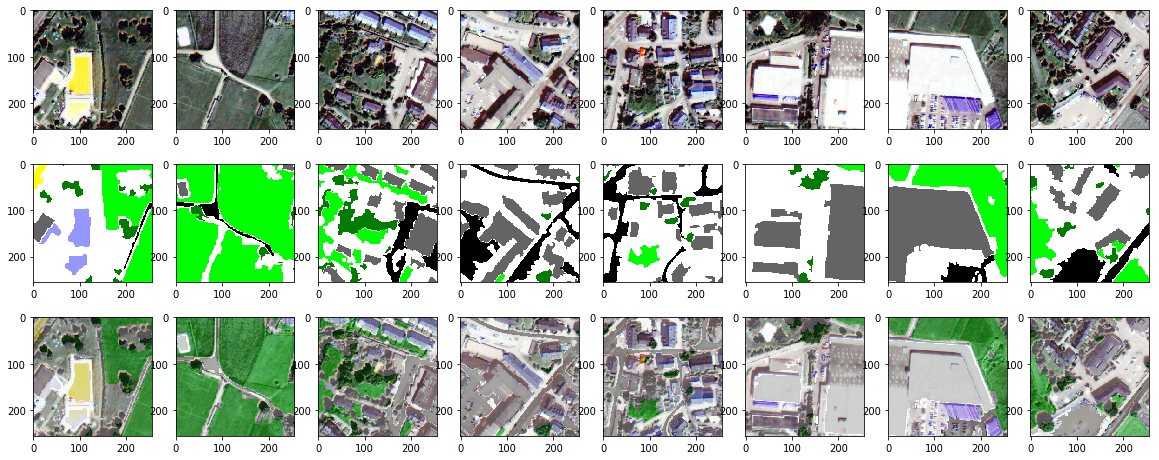

In [534]:
imgs_row = 8
fig, axes = plt.subplots(3,imgs_row)
fig.set_size_inches(20,8)
offset = 10
alpha=.3
for i in range(offset, offset + imgs_row):
    axes[0][i-offset].imshow(im_patches[i][:,:,:3])
    axes[1][i-offset].imshow(gt_label_to_color(gt_patches[i]))
    axes[2][i-offset].imshow(gt_label_to_color(gt_patches[i])*alpha+im_patches[i][:,:,:3]*(1-alpha))

# Keras CNN

Data Split: 
- Training: 12 images (512\*512)
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

To Do
- Implement pixelwise class-weighted loss function
- Test same architectures on Pytorch

In [559]:
np.random.seed(42)

from __future__ import print_function

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras import optimizers
from keras.utils import to_categorical
import keras.losses
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import *

In [560]:
x_train_im, x_test, y_train_labels_im, y_test_labels  = train_test_split(im_patches, gt_patches, test_size=.2, random_state = 42)
x_train_im, x_val_im, y_train_labels_im, y_val_labels_im  = train_test_split(x_train_im, y_train_labels_im, test_size=.25, random_state = 42)

labels_unique = np.unique(y_train_labels_im.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train_labels_im.flatten())    
class_weights[0] = 0 # give less weight to background label class
class_weights[5] = 1 # give less weight to bare soil class
class_weights[8] = 1 # give less weight to swimming pool class
#class_weights = np.concatenate([class_weights, [1]])
#class_weights.append(1) # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f"%(names[i],w))

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Class weights:
     Background: 0.000
          Roads: 0.741
      Buildings: 0.539
          Trees: 1.121
          Grass: 1.512
      Bare Soil: 1.000
          Water: 2.623
       Railways: 5.881
 Swimming Pools: 1.000


In [561]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train_im)
x_val = np.asarray(x_val_im)
x_test = np.asarray(x_test_im)

# make y data categorical
y_train = to_categorical(y_train_labels_im, n_classes)
y_val = to_categorical(y_val_labels_im, n_classes)

In [562]:
# remove background class
y_train = y_train[:,:,:,1:]
y_val = y_val[:,:,:,1:]
n_classes = n_classes -1 
class_weights = class_weights[1:]

In [563]:
# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

(189, 256, 256, 4)
(189, 256, 256, 8)
(63, 256, 256, 4)
(63, 256, 256, 8)


## UNET

In [540]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch = 0
        self.losses = []
        self.acc = []
        self.val_acc=[]
        self.acc_fn = []
        self.val_acc_fn=[]
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.acc_fn.append(logs.get('fn'))
        self.val_acc_fn.append(logs.get('val_fn'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epoch += 1
        fig, axes = plt.subplots(1, 3, sharex=True)
        fig.set_size_inches((20,6))
        
        clear_output()
        
        axes[0].plot(np.arange(self.epoch), self.losses, label="Training")
        axes[0].plot(np.arange(self.epoch), self.val_losses, label="Validation")
        axes[0].legend()
        
        axes[1].plot(np.arange(self.epoch), self.acc, label="Training")
        axes[1].plot(np.arange(self.epoch), self.val_acc, label="Validation")
        axes[1].legend()
        
        axes[2].plot(np.arange(self.epoch), self.acc_fn, label="Training")
        axes[2].plot(np.arange(self.epoch), self.val_acc_fn, label="Validation")
        axes[2].legend()
        
        axes[0].set_title("Loss")
        axes[1].set_title("Accuracy")
        axes[2].set_title("Accuracy (wo. background)")
        plt.show();
        

# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improive
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto', 
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
#filepath="weights-improvement.hdf5"
#callback_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [541]:
import numpy as np


def augment_images_and_gt(im_patches, gt_patches, normalize=False, rf_h=True, rf_v=True, rot=True, jitter=False):
    """
    :param im_patches: Image to transform
    :param gt_patches: Ground truth to transform
    :param rot: Rotations by +/- 90 degrees
    :param normalize: normalization (default:False)
    :param rf_h: Random horizontal flipping (default: True)
    :param rf_v: Random vertica flipping (default: True)
    :param rot: Randomly rotate image by 0, 90, 180 or 270 degrees (default: True)
    :param jitter: Add random noise in N(0,0.01) to image
    :return: augmented image and ground truth
    """

    im_patches_t = []  # transformed images
    gt_patches_t = []  # transformed labels
    #  normalize image between range (0,1)
    if len(np.shape(im_patches)) < 4:
        flag_singleimg = True
        im_patches = im_patches[np.newaxis]
        gt_patches = gt_patches[np.newaxis]
    else:
        flag_singleimg = False

    for (im, gt) in zip(im_patches, gt_patches):
        if normalize:
            im /= np.max(im)

        # random flipping
        if rf_h:
            if np.random.randint(2):
                im = np.fliplr(im)
                gt = np.fliplr(gt)
        if rf_v:
            if np.random.randint(2):
                im = np.flipud(im)
                gt = np.flipud(gt)

        # rotation
        if rot:
            if np.random.choice([0, 1], p=[.25, .75]):
                k = np.random.randint(1, 4)  # rotate 1, 2 or 3 times by 90 degrees
                im = np.rot90(im, k)
                gt = np.rot90(gt, k)

        # noise injection (jittering), only for image
        if jitter:
            if np.random.randint(2):
                noise = np.random.normal(0, .01, np.shape(im))
                im += noise

        # Scale image between [0, 1]
        im -= np.min(im)
        im /= np.max(im)

        im_patches_t.append(im)
        gt_patches_t.append(gt)

    if flag_singleimg:
        return im_patches_t[0], gt_patches_t[0]
    else:
        return im_patches_t, gt_patches_t


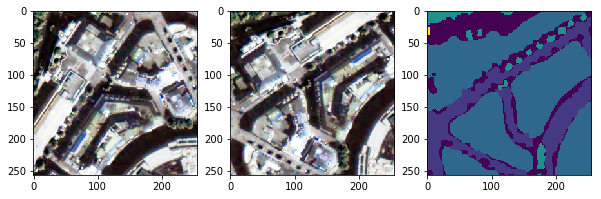

In [542]:
img_idx = 14
im_patches_vis, gt_patches_vis = augment_images_and_gt(x_train_im[img_idx], y_train_labels_im[img_idx], rf_h=True, rf_v=True, rot=True)

fig, axes = plt.subplots(1,3)
fig.set_size_inches((10,5))
axes[0].imshow(x_train_im[img_idx][:,:,:3])
axes[1].imshow(im_patches_vis[:,:,:3])
axes[2].imshow(gt_patches_vis)
plt.show()

In [543]:
# custom data generator
def batch_generator(X, y, batch_size, data_augmentation=False):
    '''
    Return [batch_size] random images from X, y
    '''
    
    while True:
        # choose batch_size random images / labels from the data
        idx = np.random.randint(0, X.shape[0], batch_size)
        im_patches = X[idx]
        gt_patches = y[idx]
        if data_augmentation:
            im_patches_t, gt_patches_t = augment_images_and_gt(im_patches, gt_patches, rf_h=True, rf_v=True, rot=True)

        yield im_patches, gt_patches

In [544]:
def ignore_background_class_accuracy(background_class_id):
    def fn(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_preds = K.argmax(y_pred, axis=-1)
        
        # Replace class_id_preds with class_id_true for recall here
        accuracy_mask = K.cast(K.not_equal(class_id_true, background_class_id), 'int32')
        class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
        class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
        return class_acc
    return fn

In [545]:
# TODO test this function
"""
from keras.backend.tensorflow_backend import _to_tensor

def weighted_pixelwise_crossentropy(class_weights):
    def loss(y_true, y_pred):
        mask = K.ones_like(y_pred)[:, :, :, 0]
        for i in range(len(class_weights)):
            mask_class_weight = K.ones_like(mask) * class_weights[i]
            mask = K.tf.where(y_true[:, :, :, i] > 0, mask_class_weight, mask)
        loss = mask * K.categorical_crossentropy(y_true, y_pred)
        return loss
    return loss
"""

'\nfrom keras.backend.tensorflow_backend import _to_tensor\n\ndef weighted_pixelwise_crossentropy(class_weights):\n    def loss(y_true, y_pred):\n        mask = K.ones_like(y_pred)[:, :, :, 0]\n        for i in range(len(class_weights)):\n            mask_class_weight = K.ones_like(mask) * class_weights[i]\n            mask = K.tf.where(y_true[:, :, :, i] > 0, mask_class_weight, mask)\n        loss = mask * K.categorical_crossentropy(y_true, y_pred)\n        return loss\n    return loss\n'

In [546]:
def get_unet(n_classes,input_shape=x_train.shape[1:]):
    """get UNET model instance"""
    
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    conv1 = Dropout(.1)(conv1)
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(.1)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(.1)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(.1)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(.1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(.1)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(.1)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(.1)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (5, 5), activation='relu', padding='same')(up9)
    conv9 = Dropout(.1)(conv9)
    conv9 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc',ignore_background_class_accuracy(0)])

    return model

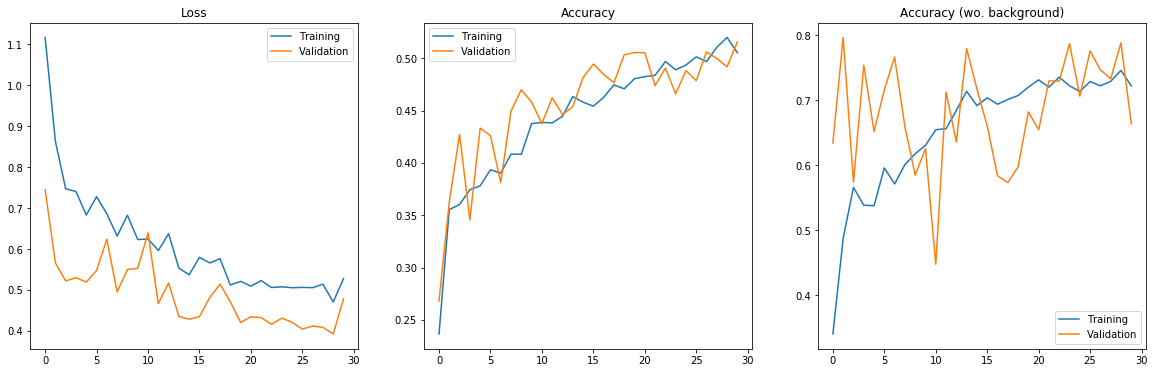

95/95 [==============================] - 26s 271ms/step - loss: 0.5276 - acc: 0.5053 - fn: 0.7220 - val_loss: 0.4782 - val_acc: 0.5158 - val_fn: 0.6635
Epoch 31/300
25/95 [======>.......................] - ETA: 16s - loss: 0.4660 - acc: 0.5462 - fn: 0.7399

Process Process-333:
Process Process-335:
Process Process-336:
Process Process-321:
Process Process-334:
Process Process-322:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/utils/data_utils.py", line 631, in data_generator_task
    self.queue.put(generator_output)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.p

KeyboardInterrupt: 

In [547]:
batch_size = 2
epochs = 300

def model_train(model, data_augmentation = True):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train, 
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight = class_weights, # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=multiprocessing.cpu_count()*2,
                        use_multiprocessing=True)

# train the model
model = get_unet(n_classes)
#model.load_weights('model_unet_64_non_augmented.h5')
model_train(model, data_augmentation = True)
#model = load_model('model_unet_64_flip_rot90.h5', custom_objects={'fn': ignore_background_class_accuracy(0)})

In [548]:
# save the model
model.save('model_unet_256_flip_rot90_more_data.h5')  # save model, weights

# Prediction

In [553]:
y_pred = model.predict(x_test, batch_size = 5, verbose = 1)
y_pred_label = np.argmax(y_pred,axis=-1)+1

63/63 [==============================] - 5s 85ms/step


In [554]:
# Get accuracy as margin between highest and second highest class
y_pred_rank = np.sort(y_pred,axis=-1) # for every pixel, get the rank
y_pred_max1 = y_pred_rank[:,:,:,-1] # second highest proba
y_pred_max2 = y_pred_rank[:,:,:,-2] # second highest proba
y_pred_acc = y_pred_max1 - y_pred_max2

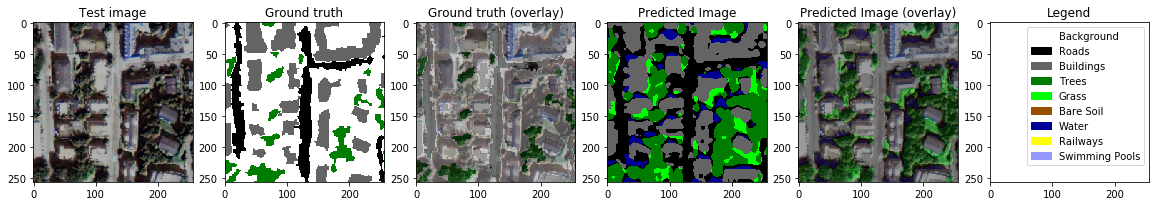

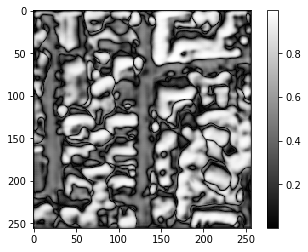

In [564]:
# plot prediction results
im_idx = 1
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_test[im_idx][:,:,:3]*(1-alpha)
fig_test = gt_label_to_color(y_test_labels_im[im_idx])
fig_pred = gt_label_to_color(y_pred_label[im_idx])

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = (v/255 for v in c)) for n,c in legend_data]
labels = [n for n,c in legend_data]
axes[5].legend(handles,labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.colorbar()

In [565]:
# convert patches to input image
def convert_patches_to_image(im_patches, patch_size=64, image_size=512, verbose=False):
    """
    Merge patches to image
    """
    n_images_row = int(np.floor(image_size/patch_size))
    n_images_out = int(np.floor(im_patches.shape[0]/(n_images_row*n_images_row)))
    print("Will output %i images" % n_images_out)
    # initialize empty image
    if(len(np.shape(im_patches))>3):
        n_channels = im_patches.shape[-1]
        images_out = np.zeros((n_images_out, image_size, image_size, n_channels))
    else:
        images_out = np.zeros((n_images_out, image_size, image_size))

    for k in range(n_images_out):
        for i in range(n_images_row):
            for j in range(n_images_row):
                patch = im_patches[k*(n_images_row**2)+(i*n_images_row+j)]
                images_out[k, i*patch_size:i*patch_size+patch_size, j*patch_size:j*patch_size+patch_size] = patch
                
    return images_out

images_out = convert_patches_to_image(gt_label_to_color(y_pred_label), patch_size = patch_size, image_size = 512)
images_out_gt = convert_patches_to_image(gt_label_to_color(y_test_labels), patch_size = patch_size, image_size = 512)
print(images_out.shape)
print(images_out_gt.shape)

Will output 15 images
Will output 15 images
(15, 512, 512, 3)
(15, 512, 512, 3)


In [566]:
"""
fig, axes = plt.subplots(1,3)
fig.set_size_inches((15,8))
img_idx = 0
axes[0].imshow(images_out[img_idx])
axes[1].imshow(images_out_gt[img_idx])
axes[2].imshow(x_test_im[img_idx,:,:,:3])
plt.show()
"""

# TO DO: avoid boundary effect by tiling with a stride less than the patch size.

'\nfig, axes = plt.subplots(1,3)\nfig.set_size_inches((15,8))\nimg_idx = 0\naxes[0].imshow(images_out[img_idx])\naxes[1].imshow(images_out_gt[img_idx])\naxes[2].imshow(x_test_im[img_idx,:,:,:3])\nplt.show()\n'

# Accuracy metrics

In [567]:
y_pred.shape

(63, 256, 256, 8)

In [568]:
# Validation accuracy
# mask background class for evaluation

#TODO ditinguish overall / average accuracy

print("Testing accuracy: %.3f" % sklearn.metrics.accuracy_score(y_pred_label[y_test_labels!=0].flatten(),y_test_labels[y_test_labels!=0].flatten()))
print(sklearn.metrics.classification_report(
    y_pred_label[y_test_labels!=0].flatten(),
    y_test_labels[y_test_labels!=0].flatten(),
    target_names=labels[1:],
    digits=3))

Testing accuracy: 0.722
                precision    recall  f1-score   support

         Roads      0.603     0.691     0.644    578746
     Buildings      0.800     0.688     0.740    925538
         Trees      0.882     0.764     0.818    377347
         Grass      0.731     0.826     0.776    312960
     Bare Soil      0.000     0.000     0.000         0
         Water      0.788     0.726     0.755    215769
      Railways      0.000     0.000     0.000         0
Swimming Pools      0.000     0.000     0.000         0

   avg / total      0.756     0.722     0.735   2410360



# Certainty using Density Forest)

In [569]:
# from https://github.com/keras-team/keras/issues/41
from keras import backend as K

def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return np.asarray(activations[0])

activations = get_activations(model, -2, x_test)

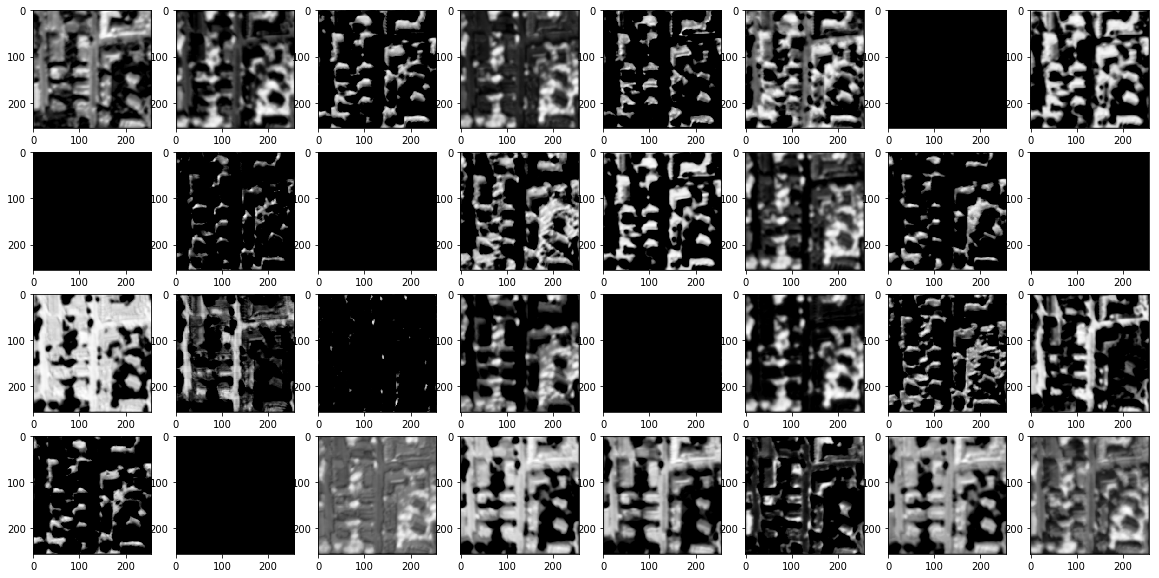

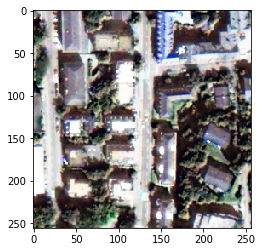

In [574]:
# visualize some activations
fig, axes = plt.subplots(4,8)
fig.set_size_inches(20,10)
for i in range(4):
    for j in range(8):
        axes[i][j].imshow(activations[im_idx][:,:,i*8+j],cmap='Greys_r')
plt.show()

plt.figure()
plt.imshow(x_test[im_idx][:,:,:3])
plt.show()

# Density Forest Uncertainty Measure
Feed activation weigths into density tree

In [72]:
import sys
sys.path.append('/home/cyrilwendl/SIE-Master/Code') # Path to density Tree package
sys.path.append('/home/cyrilwendl/SIE-Master/Code/density_tree') # Path to density Tree package

from density_tree import density_tree
from density_tree.density_forest import *
from density_tree.density_tree_create import create_density_tree
from sklearn import decomposition
import warnings

In [73]:
activations_2D = np.reshape(activations, (activations.shape[0]*activations.shape[1]*activations.shape[2],activations.shape[3]))

Variance explained by first 5 components: 0.96


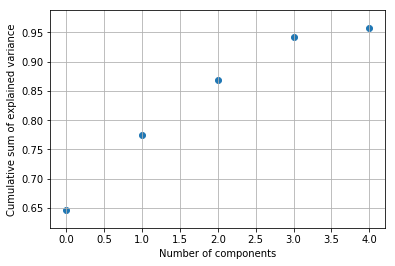

In [74]:
# create density tree for activation weights of training data
dimensions = np.shape(activations_2D)[-1]

# PCA
pca = decomposition.PCA(n_components=10)
pca.fit(activations_2D)
n_components = len(pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_)<.95])+1
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
pca = decomposition.PCA(n_components=n_components)
pca.fit(activations_2D)

plt.cla()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.show()

In [75]:
X_all = pca.transform(activations_2D)
y_val_1D = np.reshape(y_val_labels,(y_val_labels.shape[0]*y_val_labels.shape[1]*y_val_labels.shape[2]))

In [76]:
n_points = 1000
dataset_indices = np.arange(len(X_all))

#  draw random samples with replacement
dataset_subset_indices = np.random.choice(dataset_indices, size=n_points, replace=True,)
dataset_subset = X_all[dataset_subset_indices, :]

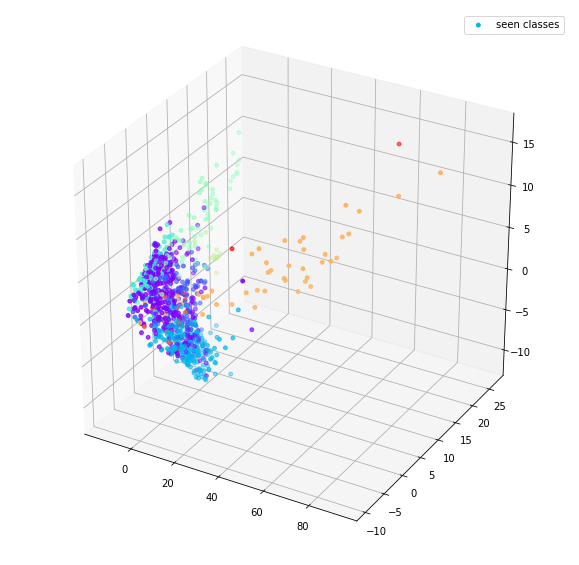

In [77]:
# for interactive Jupyter Notebook
# %matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_all[dataset_subset_indices,0], X_all[dataset_subset_indices,1], zs=X_all[dataset_subset_indices,2], c=y_val_1D[dataset_subset_indices], cmap=plt.get_cmap('rainbow'), s=15)
#ax.scatter(X_unseen[:,0], X_unseen[:,1], zs=X_unseen[:,2], c='black', s=30, marker='x', depthshade=False) 
ax.legend(['seen classes','unseen class'])

#plt.savefig("../Figures/pca_components_3d.pdf", bbox_inches='tight', pad_inches=0)
#plt.show()

In [78]:
print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

Variance explained by first 3 components: 0.87


In [79]:
warnings.filterwarnings("ignore")
#root = create_density_tree(X_all, dimensions = n_components, clusters = n_classes, verbose = True)

In [80]:
warnings.filterwarnings("ignore")
subset_data = 0.001
print("Number of points on which to train trees: %i" % int(np.shape(X_all)[0] * subset_data))
root_nodes_seen = density_forest_create(X_all, n_components, n_classes, 10, subset_data, -1)

Number of points on which to train trees: 1048


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.3s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.6s finished


In [81]:
# get probabilities for one image
n_jobs = multiprocessing.cpu_count()
n_images = 256  # len(y_test)
probas_seen = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(density_forest_traverse)(X_all[im_idx*(patch_size * patch_size):(im_idx+1)*(patch_size * patch_size),:], root_nodes_seen, thresh = .1)
        for im_idx in range(n_images))

#probas_seen = density_forest_traverse(X_all[im_idx*(patch_size * patch_size):(im_idx+1)*(patch_size * patch_size),:], root_nodes_seen, thresh = .1)

100%|██████████| 4096/4096 [00:11<00:00, 358.16it/s] 


100%|██████████| 4096/4096 [00:12<00:00, 317.50it/s]

100%|██████████| 4096/4096 [00:10<00:00, 378.00it/s]
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:  6.3min finished


In [82]:
probas_seen_im = np.reshape(probas_seen.copy(), (n_images, patch_size, patch_size))

#ad-hoc scaling of probabilities
probas_seen_im = np.log(probas_seen_im)
probas_seen_im = np.add(probas_seen_im, -np.nanmin(probas_seen_im))
probas_seen_im = np.divide(probas_seen_im, np.nanmax(probas_seen_im))

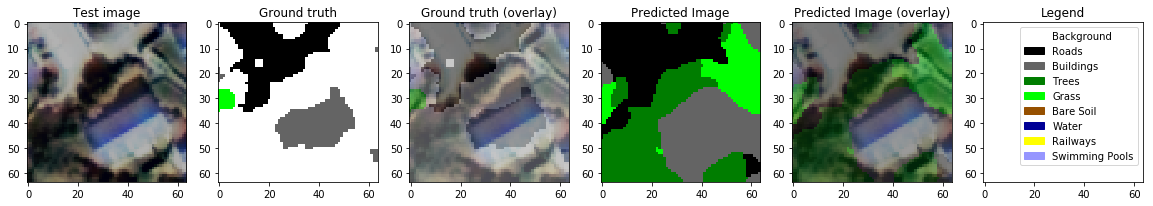

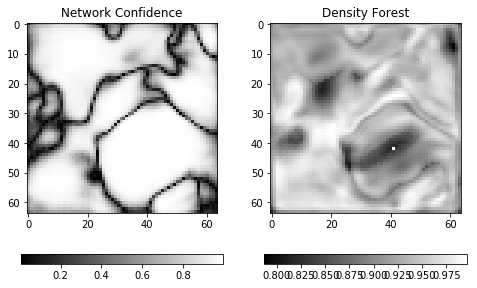

In [83]:
# plot prediction results with new uncertainty
# %matplotlib inline
im_idx = 5
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_test[im_idx][:,:,:3]*(1-alpha)
fig_test = gt_label_to_color(y_test_labels[im_idx])
fig_pred = gt_label_to_color(y_pred_label[im_idx])

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = (v/255 for v in c)) for n,c in legend_data]
labels = [n for n,c in legend_data]
axes[5].legend(handles,labels)

# show certitude by network
fig, axes = plt.subplots(1,2)
fig.set_size_inches(8,5)
f1 = axes[0].imshow(y_pred_acc[im_idx], cmap='gray')
fig.colorbar(f1, ax=axes[0], orientation='horizontal')
f2 = axes[1].imshow(probas_seen_im[im_idx], cmap='gray')
fig.colorbar(f2, ax=axes[1], orientation='horizontal',spacing='proportional')
axes[0].set_title("Network Confidence")
axes[1].set_title("Density Forest")
plt.show()

In [84]:
av_cert = []
for label in range(n_classes):
    av_cert.append(np.nanmean(probas_seen_im[y_test_labels==label])) 
    
av_cert
print("Average certainty within class:")
for i, w in enumerate(av_cert):
    print("%15s: %3.3f"%(names[i],w))

Average certainty within class:
     Background: 0.930
          Roads: 0.903
      Buildings: 0.910
          Trees: 0.951
          Grass: 0.936
      Bare Soil: 0.833
          Water: 0.864
       Railways: 0.890


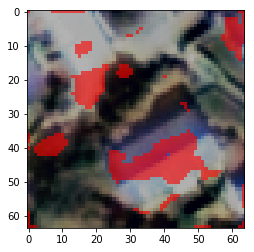

In [125]:
# show uncertain places by overlaying red polygons for certain threshold
thresh = .9 # confidence threshold
opacity = .4 # overlay opacity

red_mask = fig_im.copy()*0
red_mask[:,:,0] = 1
fig_im_overlay = fig_im.copy()
mask_vals = probas_seen_im[im_idx]<thresh
fig_im_overlay[mask_vals] = fig_im_overlay[mask_vals]*opacity + red_mask[mask_vals]*(1-opacity)

plt.figure()
plt.imshow(fig_im_overlay)
plt.show()